In [5]:
!pip install --upgrade pip
!pip install -r ../requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.5 MB/s eta 0:00:00 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 22.2
    Uninstalling pip-22.2:
      Successfully uninstalled pip-22.2


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 1 https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects?resource=download

# 2 https://www.kaggle.com/datasets/adityaramachandran27/nasa-near-earth-objects-information ESTA

In [14]:
df_raw = pd.read_csv('../data/2/NASA Near-Earth Objects.csv')

### Diccionario de datos:

- Unnamed: 0: Default index

- id: A unique ID given by NASA

- neo_reference_id: A unique ID given by NASA to all NEO, same as the ID

- name: Official name given by NASA

- name_limited: Normal name without the scientific notations

- designation: The number used in the official name given by NASA

- absolute_magnitude_h: Absolute magnitude (M) is a measure of the luminosity of a celestial object, on an inverse logarithmic astronomical

- is_potentially_hazardous_asteroid: Boolean value which tells if the object poses a threat to earth or not

- is_sentry_object: Boolean value which tells if the object is present in the sentry tracking system or not (Sentry: https://en.wikipedia.org/wiki/Sentry_(monitoring_system))

- kilometers_estimated_diameter_min: Minimum estimated diameter in kilometer

- kilometers_estimated_diameter_max: Maximum estimated diameter in kilometer

- orbit_id: A unique ID for the orbit of the object

- orbit_class_type: Classification of the object orbit into classes

    - (AMO is referring to Amor asteroids: near-Earth asteroids. The orbital perihelion of these objects is close to, but greater than, the orbital aphelion of Earth (a > 1.0 AU and 1.017 AU < q < 1.3 AU).

    - APO is referring to Apollo asteroids: near-Earth asteroid orbits which cross the Earth's orbit (a > 1.0 AU and q < 1.017 AU).)

- perihelion_distance: Has the perihelion distance (the point nearest to the Earth in the path of an orbiting celestial body)

- aphelion_distance: Has the aphelion distance (the point in the orbit of a planet, asteroid, or object at which it is furthest from the Earth)

- first_observation_date: Date when the object was first observed

- last_observation_date: Date when the object was last observed

- orbit_class_description: The description of the orbit

In [20]:
# Aqui leemos la informacion general de los datos, vemos la dimension total, la cantidad de datos no nulos y el tipo de dato por columna

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         24000 non-null  int64  
 1   id                                 24000 non-null  int64  
 2   neo_reference_id                   24000 non-null  int64  
 3   name                               24000 non-null  object 
 4   name_limited                       144 non-null    object 
 5   designation                        24000 non-null  object 
 6   absolute_magnitude_h               23992 non-null  float64
 7   is_potentially_hazardous_asteroid  24000 non-null  bool   
 8   is_sentry_object                   24000 non-null  bool   
 9   kilometers_estimated_diameter_min  23992 non-null  float64
 10  kilometers_estimated_diameter_max  23992 non-null  float64
 11  orbit_id                           24000 non-null  obj

Observar que hay datos faltantes en columnas como 'absolute_magnitude_h ' y 'name_limited'. En el segundo caso es porque NASA no le asigna nombres propios a todos los cuerpos

In [26]:
# Se elimina la columna 'Unnamed: 0' ya que son los indices de las filas, y al importar los datos, pandas ya me los define
 
df_raw.drop(columns = ['Unnamed: 0'], inplace = True)

In [27]:
# Descripicion de variables numericas

df_raw.describe()

,id,neo_reference_id,absolute_magnitude_h,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,perihelion_distance,aphelion_distance
count,2.400000e+04,2.400000e+04,23992.000000,23992.000000,23992.000000,24000.000000,24000.000000
mean,7.275111e+06,7.275111e+06,22.942274,0.167777,0.375160,0.915225,2.653104
std,1.333987e+07,1.333987e+07,2.952871,0.293000,0.655169,0.232201,4.468233
min,2.001981e+06,2.001981e+06,12.580000,0.000609,0.001362,0.070431,0.653754
25%,3.409962e+06,3.409962e+06,20.650000,0.024241,0.054205,0.785150,1.706281
50%,3.703790e+06,3.703790e+06,23.200000,0.060891,0.136157,0.965325,2.480109
75%,3.803897e+06,3.803897e+06,25.200000,0.197040,0.440595,1.068984,3.397965
max,5.408749e+07,5.408749e+07,33.200000,8.101305,18.115068,1.299988,631.895456


In [28]:
# Descripicion de variables categoricas (object, bool, en este caso)

df_raw.describe(include = ['object','bool'])

,name,name_limited,designation,is_potentially_hazardous_asteroid,is_sentry_object,orbit_id,orbit_class_type,first_observation_date,last_observation_date,orbit_class_description
count,24000,144,24000,24000,24000,24000,24000,24000,24000,24000
unique,24000,144,24000,2,2,352,4,5964,5016,4
top,1981 Midas (1973 EA),Midas,1981,False,False,7,APO,2014-04-23,2022-04-15,Near-Earth asteroid orbits which cross the Ear...
freq,1,1,1,21906,22934,1485,13245,67,40,13245


Podemos ver que la asignacion de nombres por parte de la NASA es unica, ya que en las columnas 'name', 'name_limited' y 'designation' tenemos todos valores unicos. Vamos a chequear tambien en la columna 'id' si se cumple

In [31]:
df_raw['id'].duplicated().any()

False

In [32]:
# Muestra de los datos

df_raw.sample(5)

,id,neo_reference_id,name,name_limited,designation,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_id,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date,orbit_class_description
22900,54017253,54017253,(2020 KE5),NaN,2020 KE5,21.90,False,False,0.110804,0.247765,7,APO,0.864417,3.185651,2020-05-23,2021-01-03,Near-Earth asteroid orbits which cross the Ear...
7070,3484923,3484923,(2010 AC3),NaN,2010 AC3,22.50,False,False,0.084053,0.187949,8,AMO,1.107440,2.337476,2010-01-08,2010-01-14,Near-Earth asteroid orbits similar to that of ...
16798,3785920,3785920,(2017 TO5),NaN,2017 TO5,25.30,False,False,0.023150,0.051765,7,AMO,1.096820,2.664769,2017-10-13,2017-11-09,Near-Earth asteroid orbits similar to that of ...
20547,3843547,3843547,(2019 PR2),NaN,2019 PR2,18.79,False,False,0.464040,1.037624,63,AMO,1.165470,10.374658,2005-10-27,2020-03-30,Near-Earth asteroid orbits similar to that of ...
2788,2524392,2524392,524392 (2002 AU5),NaN,524392,17.85,False,False,0.715410,1.599705,66,APO,0.496398,3.544280,2001-06-16,2022-03-28,Near-Earth asteroid orbits which cross the Ear...


#### Primeras observaciones

- Las columnas 'id' y 'neo_reference_id' son identicas, asi que nos podemos quedar solo con una de ellas
- La columna 'name_limited' es simplemente la extraccion del nombre propio del cuerpo (si es que lo tiene), dato que ya esta en la columna 'name', por lo que no nos presenta informacion relevante, mas alla de sacar la proporcion de cuerpos a los que la NASA le ha asignado un valor propio. 
- Algo similar sucede con la columna 'designation', la cual tambien es una parte del nombre oficial establecido, y el dato completo del nombre esta en la columna 'name'

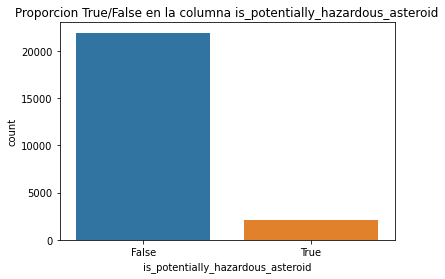

In [44]:
# is_potentially_hazardous_asteroid	is_sentry_object
fig, ax =plt.subplots(1,2)
sns.countplot(x = df_raw['is_potentially_hazardous_asteroid'], ax=ax[0])
plt.title('Proporcion True/False en la columna is_potentially_hazardous_asteroid')

